In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('../data/raw_data.csv')

In [3]:
df = df[df['y'].notnull()]
df.shape

(343, 14)

In [4]:
df_clean = pd.DataFrame(index=df.index)

In [5]:
clean_date = df['watch-time-text'].str.extract(r"(\d+) de ([a-z]+)\. de (\d+)")

In [6]:
clean_date[0] = clean_date[0].dropna().astype(str)
clean_date[2] = clean_date[2].dropna().astype(str)

In [7]:
month_map = {"jan": "Jan",
             "fev": "Feb",
             "mar": "Mar",
             "abr": "Apr",
             "mai": "May",
             "jun": "Jun",
             "jul": "Jul",
             "ago": "Aug",
             "set": "Sep",
             "out": "Oct",
             "nov": "Nov",
             "dez": "Dec"}

clean_date[1] = clean_date[1].map(month_map)

In [8]:
clean_date = clean_date.dropna().apply(lambda x: " ".join(x), axis=1)

In [9]:
df_clean['date'] = pd.to_datetime(clean_date, format="%d %b %Y")

In [10]:
df_clean

,date
0,2010-04-30
1,2014-12-04
2,2020-03-11
3,2018-10-16
4,2019-03-10
...,...
338,2019-11-01
339,2018-04-09
340,2019-12-28
341,2020-02-02


In [11]:
views = df['watch-view-count'].str.extract(r"(\d+\.?\d*)",
           expand=False).str.replace(".", "").fillna(0).astype(int)
df_clean['views'] = views

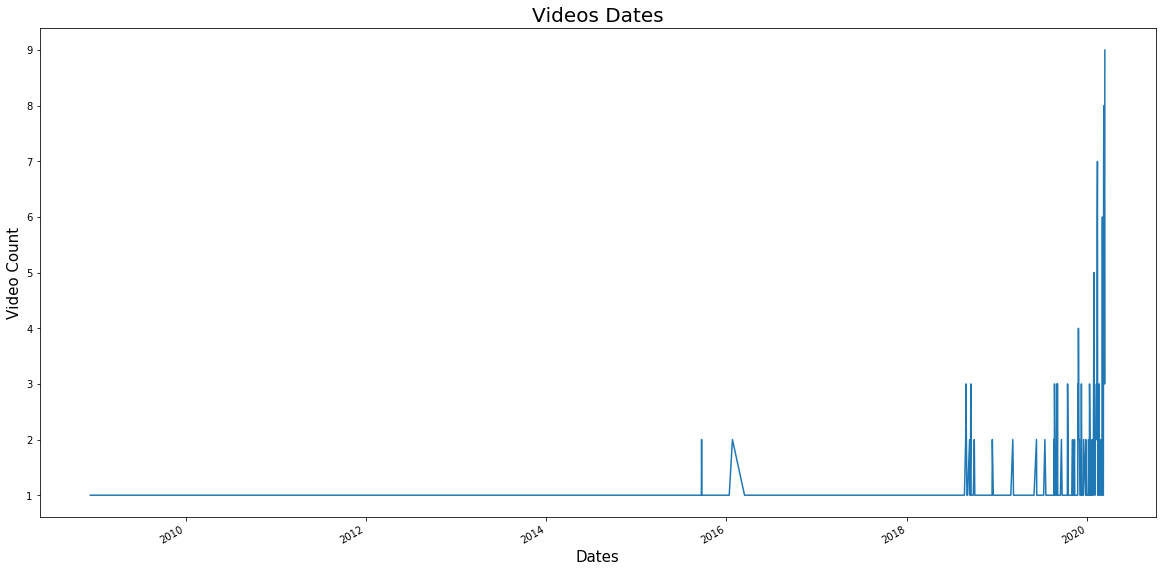

In [12]:
# Makaing features DataFrame
features = pd.DataFrame(index=df_clean.index)
y = df['y'].copy()

features['time_since_pub'] = (pd.to_datetime("2020-03-15") -  # HARDCODED
                              df_clean['date']) / np.timedelta64(1, 'D')
features['views'] = df_clean['views']
features['views_per_day'] = features['views'] / features['time_since_pub']
features = features.drop(['time_since_pub'], axis=1)

df_clean['date'].value_counts().plot(figsize=(20, 10))
plt.title('Videos Dates', fontsize=20)
plt.xlabel('Dates', fontsize=15)
plt.ylabel('Video Count', fontsize=15)
plt.savefig('../figures/video_dates.png')
plt.show()

In [13]:
features['date'] = df_clean['date']
features['index'] = features.index
features = features.set_index('date').sort_index().dropna()

In [14]:
y = pd.DataFrame(y)
y['date'] = df_clean['date']
y['index'] = y.index
y = y.set_index('date').sort_index()
y = y[y.index.notna()]

In [15]:
n = len(features)
n_train = np.ceil(n * 0.6) - 1
n_val = n - n_train

In [16]:
X_train, X_val = features.reset_index().loc[:n_train], features.reset_index().loc[n_train+1:]

In [17]:
y_train, y_val = y.reset_index().loc[:n_train], y.reset_index().loc[n_train+1:]

In [18]:
X_train = X_train.drop(['date', 'index'], axis=1)
X_val = X_val.drop(['date', 'index'], axis=1)
y_train = y_train['y']
y_val = y_val['y']

In [19]:
mdl = DecisionTreeClassifier(random_state=0, max_depth=3, class_weight="balanced")
mdl = mdl.fit(X_train, y_train)

In [20]:
val_proba = mdl.predict_proba(X_val)
preds = mdl.predict(X_val)

In [21]:
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
import scikitplot as skplt

In [22]:
log_loss(y_val,preds)

18.456243669248636

In [23]:
average_precision_score(y_val, val_proba[:, 1])

0.46994549922187384

In [24]:
roc_auc_score(y_val, val_proba[:, 1])

0.46140391791044777

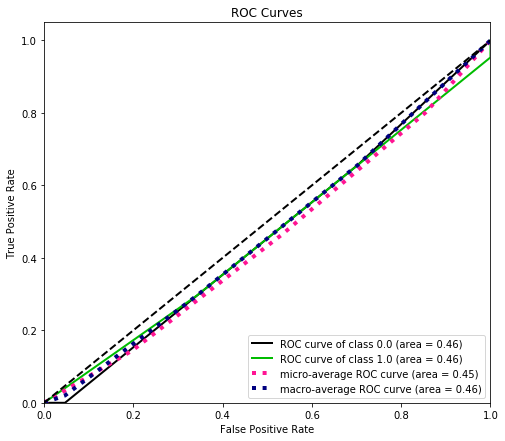

In [25]:
skplt.metrics.plot_roc(y_val, val_proba, figsize=(8,7))

In [26]:
from sklearn.tree import plot_tree

[Text(372.0, 475.65000000000003, 'views <= 133530.5\ngini = 0.5\nsamples = 198\nvalue = [99.0, 99.0]'),
 Text(279.0, 339.75, 'views_per_day <= 475.502\ngini = 0.5\nsamples = 193\nvalue = [94.733, 99.0]'),
 Text(186.0, 203.85000000000002, 'views <= 43311.0\ngini = 0.5\nsamples = 186\nvalue = [94.733, 90.549]'),
 Text(93.0, 67.94999999999999, 'gini = 0.5\nsamples = 174\nvalue = [85.345, 89.341]'),
 Text(279.0, 67.94999999999999, 'gini = 0.202\nsamples = 12\nvalue = [9.388, 1.207]'),
 Text(372.0, 203.85000000000002, 'gini = 0.0\nsamples = 7\nvalue = [0.0, 8.451]'),
 Text(465.0, 339.75, 'gini = 0.0\nsamples = 5\nvalue = [4.267, 0.0]')]

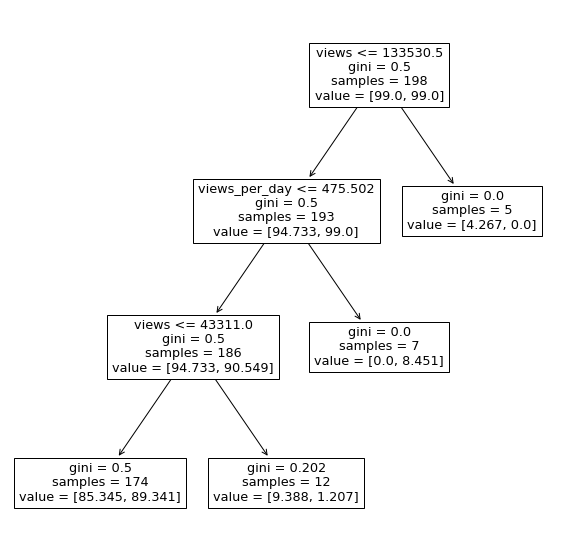

In [27]:
fig, ax = pylab.subplots(1,1, figsize=(10,10))
plot_tree(mdl, ax=ax, feature_names=X_train.columns)